# Problem izbora portfelja investicija

In [1]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sympy import symbols, Matrix, Eq, S, simplify, pprint

Podaci o godišnjim prinosima za dionice D1, D2 i D3 kroz osam godina:

In [2]:
data = [[10.4, 11.5, -1.5, 9.5, 7.4, 9.2, 6.8, 12.3],
         [7.5, 10.2, 15.2, 12.4, 18.7, 15.0, 16.3, 17.5],
         [8.3, 15.4, -2.5, -3.4, 15.8, 12.5, -1.5, 25.8]]

expected_rate_of_return = 10 # očekivani prinos od barem 10%

n = len(data)  # broj dionica 
r = len(data[0]) # broj godina 

df = pd.DataFrame(data, columns=[1, 2, 3, 4, 5, 6, 7, 8], index=['D1', 'D2', 'D3'])
df

,1,2,3,4,5,6,7,8
D1,10.4,11.5,-1.5,9.5,7.4,9.2,6.8,12.3
D2,7.5,10.2,15.2,12.4,18.7,15.0,16.3,17.5
D3,8.3,15.4,-2.5,-3.4,15.8,12.5,-1.5,25.8


## pj - prosječna stopa prinosa investicije j (j = 1, 2, ..., n)

In [3]:
def calc_p(data):
   p = []
   for j in range(n):
      p.append(sum(data[j]) / r)
   return p

p = calc_p(data)
print("[p1, p2, p3] = %s" % (p))

[p1, p2, p3] = [8.2, 14.1, 8.8]


## Varijanca investicije j:
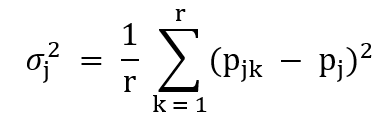

In [4]:
def calc_variance(data, p):
   sigmas = []
   for j in range(n):
      sum = 0
      for k in range(r):
         sum += (data[j][k] - p[j]) ** 2
      sigmas.append(round(sum / r, 5))
   return sigmas

var = calc_variance(data, p)
print("[σ1², σ2², σ3²] = %s" % (var))

[σ1², σ2², σ3²] = [16.49, 12.655, 97.265]


## Kovarijanca investicija i i j (i,j = 1, 2, ..., n) 
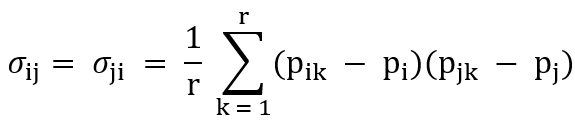

In [5]:
def calc_covariance(data, p, i, j):
   sigma = 0
   for k in range(r):
      sigma += (data[i][k] - p[i])*(data[j][k]-p[j])
   sigma = round(sigma / r, 5)
   return sigma

## Varijanca, kao mjera rizika portfelja određena je relacijom:
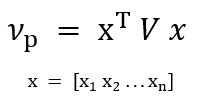
## gdje je V kovarijancna matrica:
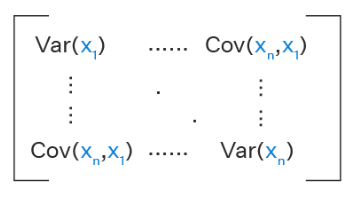

In [6]:
def covariance_matrix(data, p):
   sigma = calc_variance(data, p) 
   V = np.empty([n, n]) # nxn matrica
   for i in range(n):
      for j in range(n):
         if i == j:
            V[i][j] = sigma[j]
         else:
            V[i][j] = calc_covariance(data, p, i, j)
   return V

V = covariance_matrix(data, p)
print("V = \n")
pprint(Matrix(V))

V = 

⎡ 16.49    -4.02375  24.58125⎤
⎢                            ⎥
⎢-4.02375   12.655    7.0675 ⎥
⎢                            ⎥
⎣24.58125   7.0675    97.265 ⎦


In [7]:
x1, x2, x3 = symbols('x1 x2 x3')
xT = Matrix([[x1, x2, x3]])
x =  xT.transpose()
vp = xT.multiply(V)
vp = Matrix(vp).multiply(x)

simplify(Eq(S('vp'), vp[0]))

Eq(vp, 16.49*x1**2 - 8.0475*x1*x2 + 49.1625*x1*x3 + 12.655*x2**2 + 14.135*x2*x3 + 97.265*x3**2)

### Problem: minimizacija rizika portfelja uz ostvarni očekivani prinos od barem 10%
min vp</br>
Ograničenja: </br>
x1 + x2 + x3 = 1 </br>
8.2 * x1 + 14.1 * x2 + 8.8 * x3 >= 10 </br>
x1, x2, x3 >= 0

In [8]:
# vp = 16.49*x1^2 + 12.655*x2^2 + 97.265*x3^2 - 8.0475*x1*x2 + 49.1625*x1*x3 + 14.135*x2*x3 
def objective(x):
    x1 = x[0]
    x2 = x[1]
    x3 = x[2]
    return 16.49*x1*x1 + 12.655*x2*x2 + 97.265*x3*x3 - 8.0475*x1*x2 + 49.1625*x1*x3 + 14.135*x2*x3

# x1 + x2 + x3 = 1
def constraint1(x):
    return 1 - x[0] - x[1] - x[2]

#  8.2*x1 + 14.1*x2 + 8.8*x3 >= 10
def constraint2(x):
    return 8.2*x[0] + 14.1*x[1] + 8.8*x[2] - 10

In [9]:
b = (0, None) # >= 0
x_bounds = (b, b, b) # x1, x2, x3 >= 0

con1 = {'type': 'eq', 'fun': constraint1 }
con2 = {'type': 'ineq', 'fun': constraint2 }
cons = [con1, con2]

x0 = [0,0,0]

solution = minimize(objective, x0, method='SLSQP', bounds=x_bounds, constraints=cons)

In [10]:
x1 = solution.x[0]
x2 = solution.x[1]
x3 = solution.x[2]
vp = solution.fun
exp_return_on_investment = 8.2*x1 + 14.1*x2 + 8.8*x3

print("x1 = %.4f" % (x1))
print("x2 = %.4f" % (x2))
print("x3 = %.4f" % (x3))
print("vp = %.4f" % (vp))
print("Očekivani prinos: 8.2*x1 + 14.1*x2 + 8.8*x3 = %.4f" % (exp_return_on_investment))

x1 = 0.4484
x2 = 0.5516
x3 = 0.0000
vp = 5.1755
Očekivani prinos: 8.2*x1 + 14.1*x2 + 8.8*x3 = 11.4542


Prema tome uz minimalni rizik vp = 5.1755 treba uložiti 44.84% sredstava u dionice D1, a 55.16% sredstava u dionice D2.